# Testing and Validating S4 code against Fresnel Equations

This notebook will serve as an **Integration Test** of the S4 simulation, computing the **Reflection** and **Transmission** coefficients for a simple air to glass interface.

First, we import:

- `matplotlib`: plotting
- `numpy`: array/matrix, general math, etc.
- `pprint`: because we all want to be pretty
- `S4`: This is what we are testing

In [1]:
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
# extra functions used for plotting, progress bars, etc.
import util

import S4

# S4 Simulation

This example is adapted from the original example contained in `S4/examples/0d/fabry-perot/fresnel.lua`

**Note: A current bug is resulting in the need of extra "dummy layers" to enable proper reflection/transmission reading between the air and glass interface**

Outline of the code:

1. Create new simulation
2. Set the number of fourier modes to consider (in this very simple example, only 1 mode contributes. Setting `num_g > 1` will have no effect on the final results
3. Initialize the system:
    a. 1D lattice with a "unit cell" of 1.0 (we could just as easily specify a 2D lattice, but given we are using unpatterned layers, it makes no difference)
    b. Two different materials:
        1. vacuum: n=1, k=0
        2. galss: n=1.52, k=1
    c. Two different layers:
        1. Air (with dummy layer)
        2. Glass (with dummy layer)
4. Set the frequency of light (in this we again choose 1.0)
5. Scan from \\( 0^{\circ} \lt \phi \lt 90^{\circ} \\)
    a. Set the incident light parameters
    b. Get the poynting (power) flux from above and below to determin reflection and transmission coefficients

In [2]:
# Create a simulation object
S = S4.Simulation()
S.create_new()

# set number of fourier modes
S.set_num_g(1)

# Set the lattice constant; for 2D make sure you include two 2D vectors
# either will return the same results in this simulation
S.set_lattice(1)
# S.set_lattice([[1.0, 0.0], [0.0, 1.0]])

# set the index of refraction
n1 = 1.0
n2 = 1.52

# add the materials to the simulation
# Note: epsilon, not n, is used
S.add_material("vacuum", [n1**2, 0.0])
S.add_material("glass", [n2**2, 0.0])

# for now, use dummy layers to ensure the values read are correct
S.add_layer("AirAbove", 0.0, "vacuum")
S.add_layer("AirMiddle", 0.0, "vacuum")
S.add_layer("GlassMiddle", 0.0, "glass")
S.add_layer("GlassBelow", 0.0, "glass")

# set frequency to unity
f = 1.0
S.set_frequency(f)

# set angles to simulate
phis = np.linspace(0.0, 90.0, 181)


# initialize arrays for raw output
raw_tm_top = np.zeros(shape=(181,4))
raw_tm_bot = np.zeros(shape=(181,4))
raw_te_top = np.zeros(shape=(181,4))
raw_te_bot = np.zeros(shape=(181,4))
# initialize arrays to hold reflection and transmission values
te_reflection = np.zeros(shape=(181,))
te_transmission = np.zeros(shape=(181,))
tm_reflection = np.zeros(shape=(181,))
tm_transmission = np.zeros(shape=(181,))

# simulate the system at every incident angle
for i, phi in enumerate(util.log_progress(phis, every=1)):
    # set the incident planewave: tm polarization
    S.set_excitation_planewave([phi, 0.0], # incident angle: (phi, theta)
                               [0.0, 0.0], # s polarization
                               [1.0, 0.0]) # p polarization
    # get the power flux above the sample; will give the incoming
    # and reflected poewr
    out = S.get_poynting_flux("AirAbove", 0.0)
    raw_tm_top[i] = out
    [inc1, back1, _, _] = out
#     [inc1, back1, _, _] = S.get_poynting_flux("AirAbove", 0.0)
    # get the transmitted power through the bottom of the sample
    out = S.get_poynting_flux("GlassBelow", 0.0)
    raw_tm_bot[i] = out
    [forw1, _, _, _] = out
#     [forw1, _, _, _] = S.get_poynting_flux("GlassBelow", 0.0)
    # take the ratio to determine the coefficients
    tm_reflection[i] = -back1/inc1
    tm_transmission[i] = forw1/inc1
    
    # set the incident planewave: te polarization
    S.set_excitation_planewave([phi, 0.0], [1.0, 0.0], [0.0, 0.0])
    out = S.get_poynting_flux("AirAbove", 0.0)
    raw_te_top[i] = out
    [inc1, back1, _, _] = out
#     [inc1, back1, _, _] = S.get_poynting_flux("AirAbove", 0.0)
    out = S.get_poynting_flux("GlassBelow", 0.0)
    raw_te_bot[i] = out
    [forw1, _, _, _] = out
#     [forw1, _, _, _] = S.get_poynting_flux("GlassBelow", 0.0)
    te_reflection[i] = -back1/inc1
    te_transmission[i] = forw1/inc1

# Analyze the results

First, let's plot the raw output:

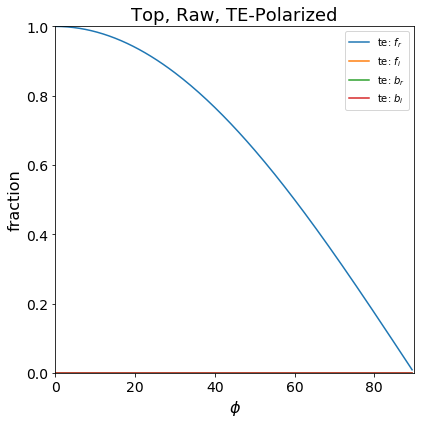

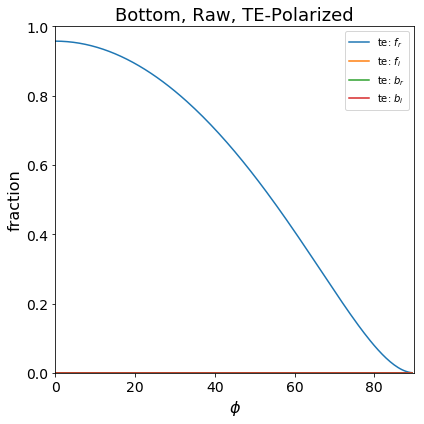

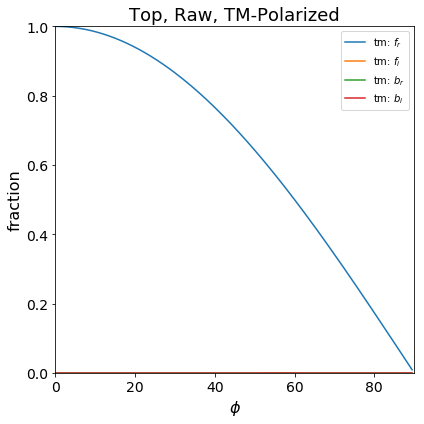

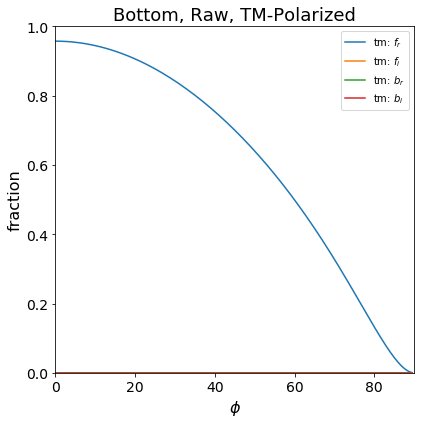

In [3]:
# create arrays to plot
x_arrs = np.zeros(shape=(4,phis.shape[0]))
y_arrs = np.zeros(shape=(4,phis.shape[0]))
# fill arrays
for i in range(4):
    x_arrs[i,:] = phis[:]
    y_arrs[i,:] = raw_te_top[:,i]
label_arr = [r"te: $f_r$", r"te: $f_i$", r"te: $b_r$", r"te: $b_i$"]
# plot
fig, _ = util.mpl_plot(x_arrs, y_arrs, label_arr,
                    r"$\phi$", r"fraction", "Top, Raw, TE-Polarized")
plt.tight_layout()
plt.show()

# create arrays to plot
x_arrs = np.zeros(shape=(4,phis.shape[0]))
y_arrs = np.zeros(shape=(4,phis.shape[0]))
# fill arrays
for i in range(4):
    x_arrs[i,:] = phis[:]
    y_arrs[i,:] = raw_te_bot[:,i]
label_arr = [r"te: $f_r$", r"te: $f_i$", r"te: $b_r$", r"te: $b_i$"]
# plot
fig, _ = util.mpl_plot(x_arrs, y_arrs, label_arr,
                    r"$\phi$", r"fraction", "Bottom, Raw, TE-Polarized")
plt.tight_layout()
plt.show()

# create arrays to plot
x_arrs = np.zeros(shape=(4,phis.shape[0]))
y_arrs = np.zeros(shape=(4,phis.shape[0]))
# fill arrays
for i in range(4):
    x_arrs[i,:] = phis[:]
    y_arrs[i,:] = raw_tm_top[:,i]
label_arr = [r"tm: $f_r$", r"tm: $f_i$", r"tm: $b_r$", r"tm: $b_i$"]
# plot
fig, _ = util.mpl_plot(x_arrs, y_arrs, label_arr,
                    r"$\phi$", r"fraction", "Top, Raw, TM-Polarized")
plt.tight_layout()
plt.show()

# create arrays to plot
x_arrs = np.zeros(shape=(4,phis.shape[0]))
y_arrs = np.zeros(shape=(4,phis.shape[0]))
# fill arrays
for i in range(4):
    x_arrs[i,:] = phis[:]
    y_arrs[i,:] = raw_tm_bot[:,i]
label_arr = [r"tm: $f_r$", r"tm: $f_i$", r"tm: $b_r$", r"tm: $b_i$"]
# plot
fig, _ = util.mpl_plot(x_arrs, y_arrs, label_arr,
                    r"$\phi$", r"fraction", "Bottom, Raw, TM-Polarized")
plt.tight_layout()
plt.show()

## Compare against Fresnel equation predictions

In [4]:
# compute analytic solution from Fresnel equation, s-polarized
def fresnel_s(theta, n1, n2):
    t0 = n1*np.cos(theta)
    t1 = n2 * np.sqrt(1.0 - np.power((n1/n2) * np.sin(theta), 2))
    numerator = t0 - t1
    denomenator = t0 + t1 
    return np.power(abs(numerator/denomenator), 2)

# compute analytic solution from Fresnel equation, p-polarized
def fresnel_p(theta, n1, n2):
    t0 = n1*np.sqrt(1.0 - np.power((n1/n2) * np.sin(theta), 2))
    t1 = n2 * np.cos(theta)
    numerator = t0 - t1
    denomenator = t0 + t1 
    return np.power(abs(numerator/denomenator), 2)

In [5]:
# Create arrays to contain the predicted Reflection and Transmission coefficients
Rste = np.array(list(map(fresnel_s, phis/180.0*np.pi, [n1 for i in phis], [n2 for i in phis])))
Tste = 1.0 - Rste

Rstm = np.array(list(map(fresnel_p,phis/180.0*np.pi, [n1 for i in phis], [n2 for i in phis])))
Tstm = 1.0 - Rstm

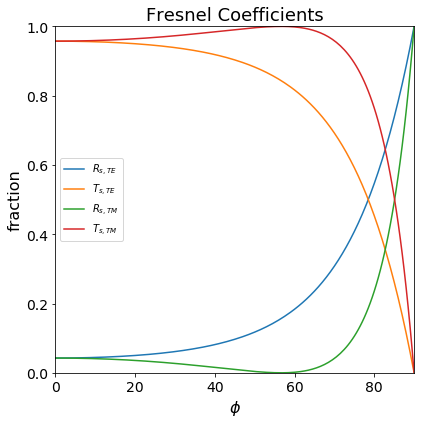

In [6]:
# create arrays to plot
x_arrs = np.zeros(shape=(4,phis.shape[0]))
y_arrs = np.zeros(shape=(4,phis.shape[0]))
# fill arrays
for i in range(4):
    x_arrs[i,:] = phis[:]
y_arrs[0,:] = Rste[:]
y_arrs[1,:] = Tste[:]
y_arrs[2,:] = Rstm[:]
y_arrs[3,:] = Tstm[:]
label_arr = [r"$R_{s,TE}$", r"$T_{s,TE}$",
             r"$R_{s,TM}$", r"$T_{s,TM}$"]
# plot
fig, ax = util.mpl_plot(x_arrs, y_arrs, label_arr,
                    r"$\phi$", r"fraction", "Fresnel Coefficients")
ax.set_xlim()
ax.set_ylim()
plt.tight_layout()
plt.show()

## plot the coefficients

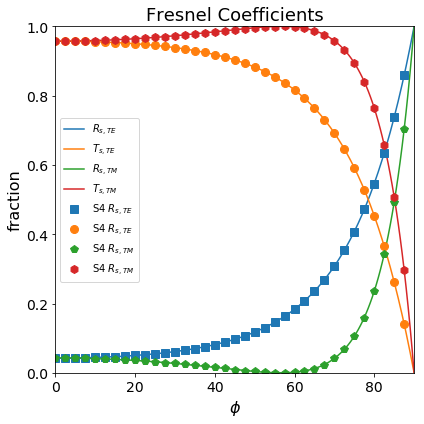

In [7]:
# create arrays to plot
x_arrs = np.zeros(shape=(4,phis.shape[0]))
y_arrs = np.zeros(shape=(4,phis.shape[0]))
# fill arrays
for i in range(4):
    x_arrs[i,:] = phis[:]
y_arrs[0,:] = Rste[:]
y_arrs[1,:] = Tste[:]
y_arrs[2,:] = Rstm[:]
y_arrs[3,:] = Tstm[:]
label_arr = [r"$R_{s,TE}$", r"$T_{s,TE}$",
             r"$R_{s,TM}$", r"$T_{s,TM}$"]
# plot
fig, ax = util.mpl_plot(x_arrs, y_arrs, label_arr,
                    r"$\phi$", r"fraction", "Fresnel Coefficients")
# plot the coefficients from S4
ax.plot(phis, te_reflection, marker='s', color="tab:blue",
        markevery=5, label="S4 $R_{s,TE}$", ms=8, linestyle="")
ax.plot(phis, te_transmission, marker='o', color="tab:orange",
        markevery=5, label="S4 $R_{s,TE}$", ms=8, linestyle="")
ax.plot(phis, tm_reflection, marker='p', color="tab:green",
        markevery=5, label="S4 $R_{s,TM}$", ms=8, linestyle="")
ax.plot(phis, tm_transmission, marker='h', color="tab:Red",
        markevery=5, label="S4 $R_{s,TM}$", ms=8, linestyle="")
ax.legend()
plt.tight_layout()
plt.show()

# Brewster's Angle

[Brewster's Angle](https://en.wikipedia.org/wiki/Brewster%27s_angle) gives the angle of incidence for which light will perfectly transmit through a material, given that light is polarized (in this case TM polarized).

$$ \theta_B = \arctan \frac{n_2}{n_1} $$

In this system, that would be:

In [8]:
theta_b = np.arctan2(n2,n1)*180.0/np.pi
# find closest index computed
idx = (np.abs(phis - theta_b)).argmin()
phi_max = phis[idx]
tm_max = tm_transmission[idx]
print(f"Brewster's Angle is {theta_b}")
print(f"The closest phi in the dataset is phi={phi_max} with a transmission={tm_max}")

Brewster's Angle is 56.659292653523
The closest phi in the dataset is phi=56.5 with a transmission=0.9999970739662406
